### Import Package

In [159]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from stockstats import StockDataFrame

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVR

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

from math import floor

### Set the data source path

In [2]:
# Set the data source path
interval = "daily"
region = "us"
ex_product = "nasdaq stocks"
section = "1"
stock = "aapl"
data_path = "test_data/"+interval+"/"+region+"/"+ex_product+"/"+section+"/"+stock+"."+region+".txt"

# Use Apple .Inc stock for training

# Extract only the OLHC
column_to_use = ["OPEN","LOW","HIGH","CLOSE"]


### Load the stock data

In [3]:
# Load the data
ori_data = pd.read_csv(data_path, sep=",")

# Rename the column names
ori_data.columns = [colname[1:-1] for colname in ori_data.columns]

# Drop the unnecessary
ori_data.index = ori_data["DATE"]
ori_data = ori_data.drop(columns=['DATE','PER','TIME', 'TICKER', 'OPENINT'])
ori_data.columns = ["open","high","low","close","volume"]

In [5]:
# Use online package to generate additional features
x = StockDataFrame(ori_data)
data = x[['open','high','low','close','volume',
          'boll', 'boll_ub', 'boll_lb',
          'macd', 'macdh', 'macds',
          'rsi_11', 'rsi_14', 'rsi_21']]


In [6]:
data

,open,high,low,close,volume,boll,boll_ub,boll_lb,macd,macdh,macds,rsi_11,rsi_14,rsi_21
DATE,,,,,,,,,,,,,,
19840907,0.10150,0.10274,0.10028,0.10150,96970899,0.101500,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
19840910,0.10150,0.10181,0.09905,0.10090,75265237,0.101200,0.102049,0.100351,-0.000013,-0.000006,-0.000007,0.000000,0.000000,0.000000
19840911,0.10181,0.10456,0.10181,0.10274,177479896,0.101713,0.103590,0.099837,0.000040,0.000028,0.000012,77.134146,76.758045,76.303318
19840912,0.10274,0.10334,0.09966,0.09966,155043826,0.101200,0.103762,0.098638,-0.000048,-0.000040,-0.000008,31.870001,32.201239,32.592743
19840913,0.10518,0.10548,0.10518,0.10518,241475025,0.101996,0.106191,0.097801,0.000125,0.000094,0.000031,68.412723,68.025100,67.561551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211021,148.81000,149.64000,147.87000,149.48000,61420990,143.875000,149.793245,137.956755,0.375617,1.069014,-0.693396,65.673205,61.532287,57.199864
20211022,149.69000,150.18000,148.64000,148.69000,58883443,143.963500,150.121546,137.805454,0.577001,1.016318,-0.439317,61.924694,58.867114,55.611436
20211025,148.68000,149.37000,147.62110,148.64000,50720556,144.127000,150.607481,137.646519,0.724216,0.930826,-0.206610,61.679591,58.693837,55.508996


In [8]:
# Split the train and test data

def custom_split(data,start,end):
    train = (data.index >= start) & (data.index <= end)
    train_X = data[train]
    
    return train_X

# CNN_LSTM (Price Prediction)

In [9]:
train_X = custom_split(data,start = 20130101,end = 20171031)
valid_X = custom_split(data,start = 20171101,end = 20181231)
test_X = custom_split(data,start = 20190101,end = 20201231)

### Label the target result

In [10]:
# Assume we use 10 days price data to predict opening price of the 11th day
num_day_to_predict = 10


In [11]:
def produce_result_target_price(X,num_day,result_col_name = "result_price"):
    y = pd.DataFrame(np.nan, index=X.index, columns=[result_col_name])
    for i in range(len(X)-num_day):
        y.iloc[i+num_day_to_predict,0] = X.iloc[i+num_day,0]
    return y

In [12]:
train_y = produce_result_target_price(train_X,num_day_to_predict)
valid_y = produce_result_target_price(valid_X,num_day_to_predict)
test_y = produce_result_target_price(test_X,num_day_to_predict)

In [13]:
valid_y

,result_price
DATE,
20171101,NaN
20171102,NaN
20171103,NaN
20171106,NaN
20171107,NaN
...,...
20181224,36.007
20181226,36.044
20181227,37.876


### Transform the X, y data into tensor

In [14]:
def transform_data_to_tensor(X,y,num_day):
    # Initiate tensor for X
    x_first = X.iloc[0:num_day,:]
    x_mean = x_first.mean(axis=0) # Get the mean of the 10-day frame
    x_std = x_first.std(axis=0) # Get the std of the 10-day frame
    x_first = x_first.sub(x_mean, axis=1).div(x_std, axis=1) # Normalize the 10-day frame here
    
    # Initiate tensor for y
    x_open = X.iloc[0:num_day,0]
    y_val = y.iloc[num_day,:] # Get the corresponding y
    y_val = y_val.sub(x_open.mean(axis=0)).div(x_open.std(axis=0)) # Normalize the y
    
    x_tf_data = [tf.convert_to_tensor(np.array(x_first),dtype = tf.float32)]
    y_tf_data = [tf.convert_to_tensor(np.array(y_val),dtype = tf.float32)]
    
    for i in range(1,len(X)-num_day):   
        x_window = X.iloc[i:i+num_day,:] # Set the window as a 10-day frame 
        x_mean = x_window.mean(axis=0) # Get the mean of the 10-day frame
        x_std = x_window.std(axis=0) # Get the std of the 10-day frame
        x_window = x_window.sub(x_mean, axis=1).div(x_std, axis=1) # Normalize the 10-day frame here
        
        x_open = X.iloc[i:i+num_day,0] # Get the opening price of the 10-day frame
        y_val = y.iloc[i+num_day,:] # Get the corresponding y
        y_val = y_val.sub(x_open.mean(axis=0)).div(x_open.std(axis=0)) # Normalize the y
        
        x_next_tf = tf.convert_to_tensor(np.array(x_window),dtype = tf.float32)
        x_tf_data = tf.concat([x_tf_data, [x_next_tf]], 0)
        
        y_next_tf = tf.convert_to_tensor(np.array(y_val),dtype = tf.float32)
        y_tf_data = tf.concat([y_tf_data, [y_next_tf]], 0)
    return (tf.reshape(x_tf_data,(-1,10,14,1)),y_tf_data)


In [15]:
tf_train_X,tf_train_y = transform_data_to_tensor(train_X,train_y,num_day_to_predict)
tf_valid_X,tf_valid_y = transform_data_to_tensor(valid_X,valid_y,num_day_to_predict)
tf_test_X,tf_test_y = transform_data_to_tensor(test_X,test_y,num_day_to_predict)


2022-03-12 16:10:12.920175: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-12 16:10:12.920707: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 12. Tune using inter_op_parallelism_threads for best performance.


In [16]:
print(tf_train_X.shape)
print(tf_train_y.shape)
print(tf_train_X.dtype)
print(tf_train_y.dtype)

print(tf_valid_X.shape)
print(tf_valid_y.shape)
print(tf_valid_X.dtype)
print(tf_valid_y.dtype)

print(tf_test_X.shape)
print(tf_test_y.shape)
print(tf_test_X.dtype)
print(tf_test_y.dtype)

(1208, 10, 14, 1)
(1208, 1)
<dtype: 'float32'>
<dtype: 'float32'>
(282, 10, 14, 1)
(282, 1)
<dtype: 'float32'>
<dtype: 'float32'>
(495, 10, 14, 1)
(495, 1)
<dtype: 'float32'>
<dtype: 'float32'>


### Build the Model

In [17]:

def myModel(input_shape,
            encoder_unit = 100,
            repeat_vector_n = 10):
    
    inputs = layers.Input(input_shape)
    
    print("Input: ",inputs.shape)
    
    # First Convolution + MaxPooling + Dropout
    x = layers.Conv2D(filters = 64,kernel_size=(3,3), strides = (1,1), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D(pool_size=(2,2),strides=(2,1), padding='valid')(x)
    x = layers.Dropout(rate = 0.01)(x)
    print("1 Cov: ",x.shape)
    
    # Second Convolution + MaxPooling + Dropout
    x = layers.Conv2D(filters = 16,kernel_size=(3,3), strides = (1,1), activation='relu', padding='valid')(x)
    x = layers.MaxPooling2D(pool_size=(2,2),strides=(2,1), padding='valid')(x)
    x = layers.Dropout(rate = 0.01)(x)
    print("2 Cov: ",x.shape)
    
    # Flatten Layer
    x = layers.Flatten()(x)
    print("Flatten: ",x.shape)
    
    # Repeat Vector Layer
    x = layers.RepeatVector(n = repeat_vector_n)(x)
    print("RepeatVector: ",x.shape)
    
    # Connect to LSTM
    x = layers.LSTM(units = encoder_unit, input_shape=(5,1))(x)
    print("LSTM: ",x.shape)
    
    # Add the Dense Layer with relu activation
    x = layers.Dense(units = 50,activation = "relu")(x)
    print("1 Dense: ",x.shape)
    
    # Add the last Dense Layer with sigmoid activation
    outputs = layers.Dense(units = 1,activation = "sigmoid")(x)
    print("Output: ",outputs.shape)
    
    return keras.Model(inputs=inputs, outputs=outputs)


### Model Training and Fitting and Validation


In [18]:
loss_list = ["MAE"]
optimizer_list = ["Adam"]
epoch_list = [30,50,100]
batch_list = [50]
encoder_list = [50,100]
lr_list = [0.005,0.01]
train_df = pd.DataFrame(columns = ["Epoch","Batch","Optimizer","LR","Encoder Unit","Loss","Metrics","Validation"])
best_model = ""
best_valid = 99999
metrics = [keras.metrics.MeanSquaredError()]

for los in loss_list:
    for opti in optimizer_list:
        for epochs in epoch_list:
            for batchs in batch_list:
                for lr in lr_list:
                    for encoder_u in encoder_list:

                        model = myModel(input_shape=(num_day_to_predict,train_X.shape[1],1),
                                        encoder_unit = encoder_u,
                                        repeat_vector_n = 50
                                       )

                        if opti == "Adam":
                            optimizer = keras.optimizers.Adam(learning_rate=lr)

                        if los == "MAE":
                            loss = keras.losses.MeanAbsoluteError()
                        elif los == "MSE":
                            loss = keras.losses.MeanSquaredError()

                        model.compile(
                            optimizer=optimizer,
                            loss=loss,
                            metrics=metrics,
                        )

                        history = model.fit(
                                tf_train_X,
                                tf_train_y,
                                epochs = epochs,
                                steps_per_epoch = batchs,
                            )

                        results = model.evaluate(tf_valid_X, tf_valid_y, batch_size=batchs)
                        print(results)
                        print("===== Summary =====")
                        print("Epoch: ",epochs)
                        print("Batch Size: ",batchs)
                        print("Optimizer: ",opti)
                        print("Learning Rate: ",lr)
                        print("Encoder Units: ",encoder_u)
                        print("Loss Function: ", los)
                        print("Metrics: ", metrics)
                        print("Validation: ",results)
                        if results[0] < best_valid:
                            best_valid = results[0]
                            best_model = model
                        train_df = train_df.append({"Epoch": epochs,
                                                    "Batch": batchs,
                                                    "Optimizer": opti,
                                                    "LR": lr,
                                                    "Encoder Unit": encoder_u,
                                                    "Loss": los,
                                                    "Metrics": metrics,
                                                    "Validation":results}, ignore_index=True)
best_model.save("model/cnn_lstm_best")

Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 50, 128)
LSTM:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 1)
Train on 1208 samples
Epoch 1/30


2022-03-12 16:10:51.276742: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_18606_18788' and '__inference___backward_standard_lstm_18912_19397_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_19570' both implement 'lstm_de1b7df4-cf8a-448b-bc07-e0e3230875cf' but their signatures do not match.


1233/1208 [==============================] - 18s 15ms/sample - loss: 1.2080 - mean_squared_error: 2.6683
Epoch 2/30
1233/1208 [==============================] - 10s 8ms/sample - loss: 1.1435 - mean_squared_error: 2.4437
Epoch 3/30
1233/1208 [==============================] - 8s 7ms/sample - loss: 1.1031 - mean_squared_error: 2.3636
Epoch 4/30
1233/1208 [==============================] - 8s 7ms/sample - loss: 1.0714 - mean_squared_error: 2.2311
Epoch 5/30
1233/1208 [==============================] - 8s 7ms/sample - loss: 1.0908 - mean_squared_error: 2.2741
Epoch 6/30
1233/1208 [==============================] - 8s 7ms/sample - loss: 1.0545 - mean_squared_error: 2.1642
Epoch 7/30
1233/1208 [==============================] - 8s 7ms/sample - loss: 1.0304 - mean_squared_error: 2.0970
Epoch 8/30
1233/1208 [==============================] - 9s 7ms/sample - loss: 1.0464 - mean_squared_error: 2.1867
Epoch 9/30
1233/1208 [==============================] - 9s 8ms/sample - loss: 1.0144 - mean_squa

2022-03-12 16:15:18.738011: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_24508' and '__inference_standard_lstm_24397_specialized_for_model_lstm_StatefulPartitionedCall_at___inference_distributed_function_24748' both implement 'lstm_903eee1f-fcd3-41b6-be3a-632ce4c5c846' but their signatures do not match.


282/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.0452159355718194, 1.8809282]
===== Summary =====
Epoch:  30
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.005
Encoder Units:  50
Loss Function:  MAE
Metrics:  [<tensorflow.python.keras.metrics.MeanSquaredError object at 0x7fb4541f92d0>]
Validation:  [1.0452159355718194, 1.8809282]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 50, 128)
LSTM:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 1)
Train on 1208 samples
Epoch 1/30


2022-03-12 16:15:23.625665: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_27785_28270' and '__inference___backward_standard_lstm_27785_28270_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_28443' both implement 'lstm_944ea858-5a41-4ef5-a973-bfe2dda40ffc' but their signatures do not match.


1233/1208 [==============================] - 15s 12ms/sample - loss: 1.1378 - mean_squared_error: 2.3878
Epoch 2/30
1233/1208 [==============================] - 9s 7ms/sample - loss: 1.2572 - mean_squared_error: 2.7414
Epoch 3/30
1233/1208 [==============================] - 10s 8ms/sample - loss: 1.3630 - mean_squared_error: 3.0532
Epoch 4/30
1233/1208 [==============================] - 9s 8ms/sample - loss: 1.3521 - mean_squared_error: 3.0044
Epoch 5/30
1233/1208 [==============================] - 8s 6ms/sample - loss: 1.3552 - mean_squared_error: 3.0118
Epoch 6/30
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.3606 - mean_squared_error: 3.0503
Epoch 7/30
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.4003 - mean_squared_error: 3.2458
Epoch 8/30
1233/1208 [==============================] - 7s 6ms/sample - loss: 1.3146 - mean_squared_error: 2.8238
Epoch 9/30
1233/1208 [==============================] - 8s 6ms/sample - loss: 1.3619 - mean_squa

2022-03-12 16:18:52.073476: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_33381' and '__inference_standard_lstm_33270_specialized_for_model_1_lstm_1_StatefulPartitionedCall_at___inference_distributed_function_33621' both implement 'lstm_c270ec5e-8b70-4218-9f6c-ea09c904fbe7' but their signatures do not match.


282/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.052262969896303, 1.8932962]
===== Summary =====
Epoch:  30
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.005
Encoder Units:  100
Loss Function:  MAE
Metrics:  [<tensorflow.python.keras.metrics.MeanSquaredError object at 0x7fb4541f92d0>]
Validation:  [1.052262969896303, 1.8932962]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 50, 128)
LSTM:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 1)
Train on 1208 samples
Epoch 1/30


2022-03-12 16:18:55.022257: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_36352_36534' and '__inference___backward_standard_lstm_36658_37143_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_37316' both implement 'lstm_7b5e2f54-3c27-4cde-9af4-5009b0effe01' but their signatures do not match.


1233/1208 [==============================] - 8s 6ms/sample - loss: 1.1765 - mean_squared_error: 2.5422
Epoch 2/30
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.1004 - mean_squared_error: 2.3625
Epoch 3/30
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.0705 - mean_squared_error: 2.2289
Epoch 4/30
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.0419 - mean_squared_error: 2.1247
Epoch 5/30
1233/1208 [==============================] - 6s 4ms/sample - loss: 1.0343 - mean_squared_error: 2.1979
Epoch 6/30
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0316 - mean_squared_error: 2.0994
Epoch 7/30
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0209 - mean_squared_error: 2.0619
Epoch 8/30
1233/1208 [==============================] - 7s 5ms/sample - loss: 1.0728 - mean_squared_error: 2.2918
Epoch 9/30
1233/1208 [==============================] - 7s 5ms/sample - loss: 1.0449 - mean_squared

2022-03-12 16:22:03.575298: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_42143' and '__inference_standard_lstm_42143_specialized_for_model_2_lstm_2_StatefulPartitionedCall_at___inference_distributed_function_42494' both implement 'lstm_4e434bdf-98b3-4b24-a06d-7c554b74396d' but their signatures do not match.


282/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.0715465038380725, 1.9652798]
===== Summary =====
Epoch:  30
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.01
Encoder Units:  50
Loss Function:  MAE
Metrics:  [<tensorflow.python.keras.metrics.MeanSquaredError object at 0x7fb4541f92d0>]
Validation:  [1.0715465038380725, 1.9652798]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 50, 128)
LSTM:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 1)
Train on 1208 samples
Epoch 1/30


2022-03-12 16:22:07.149239: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_45531_46016' and '__inference___backward_standard_lstm_45531_46016_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_46189' both implement 'lstm_41df7be8-0af2-452e-a77d-3caf197f50e1' but their signatures do not match.


1233/1208 [==============================] - 10s 8ms/sample - loss: 1.1552 - mean_squared_error: 2.4699
Epoch 2/30
1233/1208 [==============================] - 7s 5ms/sample - loss: 1.1211 - mean_squared_error: 2.4261
Epoch 3/30
1233/1208 [==============================] - 7s 6ms/sample - loss: 1.0842 - mean_squared_error: 2.3545
Epoch 4/30
1233/1208 [==============================] - 7s 6ms/sample - loss: 1.0354 - mean_squared_error: 2.0506
Epoch 5/30
1233/1208 [==============================] - 7s 6ms/sample - loss: 1.0596 - mean_squared_error: 2.1810
Epoch 6/30
1233/1208 [==============================] - 7s 6ms/sample - loss: 1.0441 - mean_squared_error: 2.2779
Epoch 7/30
1233/1208 [==============================] - 7s 6ms/sample - loss: 1.0253 - mean_squared_error: 2.0260
Epoch 8/30
1233/1208 [==============================] - 7s 6ms/sample - loss: 1.0277 - mean_squared_error: 2.0909
Epoch 9/30
1233/1208 [==============================] - 7s 6ms/sample - loss: 1.0140 - mean_square

2022-03-12 16:25:39.819050: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_51016' and '__inference_standard_lstm_51016_specialized_for_model_3_lstm_3_StatefulPartitionedCall_at___inference_distributed_function_51367' both implement 'lstm_9c9c8712-a52f-4abf-8074-c1f7d6a3abfa' but their signatures do not match.


282/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.0779119193131197, 1.934911]
===== Summary =====
Epoch:  30
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.01
Encoder Units:  100
Loss Function:  MAE
Metrics:  [<tensorflow.python.keras.metrics.MeanSquaredError object at 0x7fb4541f92d0>]
Validation:  [1.0779119193131197, 1.934911]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 50, 128)
LSTM:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 1)
Train on 1208 samples
Epoch 1/50


2022-03-12 16:25:43.325351: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_54404_54889' and '__inference___backward_standard_lstm_54404_54889_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_55062' both implement 'lstm_b47c8c97-60b6-4dc4-b66f-65156bfcb62f' but their signatures do not match.


1233/1208 [==============================] - 9s 7ms/sample - loss: 1.1920 - mean_squared_error: 2.5645
Epoch 2/50
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.0804 - mean_squared_error: 2.2378
Epoch 3/50
1233/1208 [==============================] - 6s 4ms/sample - loss: 1.0509 - mean_squared_error: 2.1651
Epoch 4/50
1233/1208 [==============================] - 6s 4ms/sample - loss: 1.0865 - mean_squared_error: 2.3298
Epoch 5/50
1233/1208 [==============================] - 6s 4ms/sample - loss: 1.0309 - mean_squared_error: 2.0043
Epoch 6/50
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.0709 - mean_squared_error: 2.2982
Epoch 7/50
1233/1208 [==============================] - 5s 4ms/sample - loss: 0.9981 - mean_squared_error: 1.9407
Epoch 8/50
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.0363 - mean_squared_error: 2.2148
Epoch 9/50
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0615 - mean_squared

2022-03-12 16:31:05.389125: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_63040' and '__inference_standard_lstm_62929_specialized_for_model_4_lstm_4_StatefulPartitionedCall_at___inference_distributed_function_63280' both implement 'lstm_c119b11f-a367-435c-97bd-40c736795289' but their signatures do not match.


282/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.0216271382697084, 1.8219554]
===== Summary =====
Epoch:  50
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.005
Encoder Units:  50
Loss Function:  MAE
Metrics:  [<tensorflow.python.keras.metrics.MeanSquaredError object at 0x7fb4541f92d0>]
Validation:  [1.0216271382697084, 1.8219554]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 50, 128)
LSTM:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 1)
Train on 1208 samples
Epoch 1/50


2022-03-12 16:31:08.495262: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_66317_66802_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_66975' and '__inference___backward_cudnn_lstm_with_fallback_66011_66193' both implement 'lstm_8aabda42-578b-44ae-a9f6-9b9ca0aaf801' but their signatures do not match.


1233/1208 [==============================] - 9s 7ms/sample - loss: 1.1744 - mean_squared_error: 2.5390
Epoch 2/50
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0743 - mean_squared_error: 2.2381
Epoch 3/50
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0821 - mean_squared_error: 2.3211
Epoch 4/50
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0443 - mean_squared_error: 2.0995
Epoch 5/50
1233/1208 [==============================] - 7s 6ms/sample - loss: 1.0261 - mean_squared_error: 2.1586
Epoch 6/50
1233/1208 [==============================] - 7s 6ms/sample - loss: 1.0467 - mean_squared_error: 2.2216
Epoch 7/50
1233/1208 [==============================] - 7s 6ms/sample - loss: 1.2305 - mean_squared_error: 2.7607
Epoch 8/50
1233/1208 [==============================] - 7s 6ms/sample - loss: 1.3077 - mean_squared_error: 3.1827
Epoch 9/50
1233/1208 [==============================] - 7s 6ms/sample - loss: 1.1418 - mean_squared

2022-03-12 16:36:22.834132: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_74953' and '__inference_standard_lstm_74842_specialized_for_model_5_lstm_5_StatefulPartitionedCall_at___inference_distributed_function_75193' both implement 'lstm_ff0d7fec-6e75-4388-8522-9ae330742285' but their signatures do not match.


282/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.0325432677640982, 1.8623041]
===== Summary =====
Epoch:  50
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.005
Encoder Units:  100
Loss Function:  MAE
Metrics:  [<tensorflow.python.keras.metrics.MeanSquaredError object at 0x7fb4541f92d0>]
Validation:  [1.0325432677640982, 1.8623041]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 50, 128)
LSTM:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 1)
Train on 1208 samples
Epoch 1/50


2022-03-12 16:36:25.840425: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_77924_78106' and '__inference___backward_standard_lstm_78230_78715_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_78888' both implement 'lstm_ba9c2e2e-9ea1-4c22-b413-715ea5de7765' but their signatures do not match.


1233/1208 [==============================] - 8s 6ms/sample - loss: 1.1376 - mean_squared_error: 2.4261
Epoch 2/50
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.0924 - mean_squared_error: 2.3180
Epoch 3/50
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.0618 - mean_squared_error: 2.2146
Epoch 4/50
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.0686 - mean_squared_error: 2.2097
Epoch 5/50
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0598 - mean_squared_error: 2.2061
Epoch 6/50
1233/1208 [==============================] - 6s 4ms/sample - loss: 1.0874 - mean_squared_error: 2.3548
Epoch 7/50
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.0437 - mean_squared_error: 2.0159
Epoch 8/50
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.1080 - mean_squared_error: 2.4391
Epoch 9/50
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.0782 - mean_squared

2022-03-12 16:41:18.014921: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_86755' and '__inference_standard_lstm_86755_specialized_for_model_6_lstm_6_StatefulPartitionedCall_at___inference_distributed_function_87106' both implement 'lstm_de9d6bb2-b828-4d71-888b-9d0e11672778' but their signatures do not match.


282/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.0826821665391855, 1.9937755]
===== Summary =====
Epoch:  50
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.01
Encoder Units:  50
Loss Function:  MAE
Metrics:  [<tensorflow.python.keras.metrics.MeanSquaredError object at 0x7fb4541f92d0>]
Validation:  [1.0826821665391855, 1.9937755]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 50, 128)
LSTM:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 1)
Train on 1208 samples
Epoch 1/50


2022-03-12 16:41:20.691029: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_90143_90628' and '__inference___backward_standard_lstm_90143_90628_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_90801' both implement 'lstm_ba274c1b-e72f-4712-be2b-aaeeac866a22' but their signatures do not match.


1233/1208 [==============================] - 8s 7ms/sample - loss: 1.1423 - mean_squared_error: 2.4555
Epoch 2/50
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0809 - mean_squared_error: 2.2349
Epoch 3/50
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0717 - mean_squared_error: 2.2282
Epoch 4/50
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0350 - mean_squared_error: 2.1483
Epoch 5/50
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0720 - mean_squared_error: 2.2203
Epoch 6/50
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0310 - mean_squared_error: 2.1980
Epoch 7/50
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0324 - mean_squared_error: 2.0911
Epoch 8/50
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0286 - mean_squared_error: 2.0925
Epoch 9/50
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0096 - mean_squared

2022-03-12 16:46:29.306962: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_98668' and '__inference_standard_lstm_98668_specialized_for_model_7_lstm_7_StatefulPartitionedCall_at___inference_distributed_function_99019' both implement 'lstm_92041608-55fe-440c-870e-93fc48b35040' but their signatures do not match.


282/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.0859702288681734, 1.9761673]
===== Summary =====
Epoch:  50
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.01
Encoder Units:  100
Loss Function:  MAE
Metrics:  [<tensorflow.python.keras.metrics.MeanSquaredError object at 0x7fb4541f92d0>]
Validation:  [1.0859702288681734, 1.9761673]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 50, 128)
LSTM:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 1)
Train on 1208 samples
Epoch 1/100


2022-03-12 16:46:32.859927: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_101750_101932' and '__inference___backward_standard_lstm_102056_102541_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_102714' both implement 'lstm_a0a49fa6-8737-439e-8a04-ed4d5a498aac' but their signatures do not match.


1233/1208 [==============================] - 8s 6ms/sample - loss: 1.3953 - mean_squared_error: 3.4142
Epoch 2/100
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.4243 - mean_squared_error: 3.5722
Epoch 3/100
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.4190 - mean_squared_error: 3.5444
Epoch 4/100
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.1108 - mean_squared_error: 2.3394
Epoch 5/100
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.0493 - mean_squared_error: 2.2261
Epoch 6/100
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0149 - mean_squared_error: 2.0116
Epoch 7/100
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0212 - mean_squared_error: 2.1172
Epoch 8/100
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.0277 - mean_squared_error: 2.2432
Epoch 9/100
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.0068 - mean

2022-03-12 16:57:24.872491: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_118292' and '__inference_standard_lstm_118181_specialized_for_model_8_lstm_8_StatefulPartitionedCall_at___inference_distributed_function_118532' both implement 'lstm_f4e1fdf5-c031-497f-b0f8-f63237e37e53' but their signatures do not match.


282/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.0403979792662545, 1.8863058]
===== Summary =====
Epoch:  100
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.005
Encoder Units:  50
Loss Function:  MAE
Metrics:  [<tensorflow.python.keras.metrics.MeanSquaredError object at 0x7fb4541f92d0>]
Validation:  [1.0403979792662545, 1.8863058]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 50, 128)
LSTM:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 1)
Train on 1208 samples
Epoch 1/100


2022-03-12 16:57:31.759752: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_121569_122054_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_122227' and '__inference___backward_cudnn_lstm_with_fallback_121263_121445' both implement 'lstm_8039e148-f607-41a1-8369-115303c585e5' but their signatures do not match.


1233/1208 [==============================] - 19s 16ms/sample - loss: 1.1464 - mean_squared_error: 2.5365
Epoch 2/100
1233/1208 [==============================] - 10s 8ms/sample - loss: 1.0664 - mean_squared_error: 2.1787
Epoch 3/100
1233/1208 [==============================] - 10s 8ms/sample - loss: 1.0549 - mean_squared_error: 2.1754
Epoch 4/100
1233/1208 [==============================] - 10s 8ms/sample - loss: 1.1064 - mean_squared_error: 2.3500
Epoch 5/100
1233/1208 [==============================] - 10s 8ms/sample - loss: 1.1187 - mean_squared_error: 2.3425
Epoch 6/100
1233/1208 [==============================] - 10s 8ms/sample - loss: 1.0790 - mean_squared_error: 2.2836
Epoch 7/100
1233/1208 [==============================] - 9s 8ms/sample - loss: 1.0522 - mean_squared_error: 2.1979
Epoch 8/100
1233/1208 [==============================] - 9s 7ms/sample - loss: 1.0671 - mean_squared_error: 2.2623
Epoch 9/100
1233/1208 [==============================] - 9s 8ms/sample - loss: 1.0750

2022-03-12 17:10:22.977341: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_137694_specialized_for_model_9_lstm_9_StatefulPartitionedCall_at___inference_distributed_function_138045' and '__inference_cudnn_lstm_with_fallback_137805' both implement 'lstm_ba389048-02bc-409a-9953-c7a739579dbe' but their signatures do not match.


282/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.0343166961737558, 1.8434093]
===== Summary =====
Epoch:  100
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.005
Encoder Units:  100
Loss Function:  MAE
Metrics:  [<tensorflow.python.keras.metrics.MeanSquaredError object at 0x7fb4541f92d0>]
Validation:  [1.0343166961737558, 1.8434093]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 50, 128)
LSTM:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 1)
Train on 1208 samples
Epoch 1/100


2022-03-12 17:10:26.129923: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_140776_140958' and '__inference___backward_standard_lstm_141082_141567_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_141740' both implement 'lstm_b2ac370b-fc9a-4987-8ca8-1e6419eca5a8' but their signatures do not match.


1233/1208 [==============================] - 8s 7ms/sample - loss: 1.1757 - mean_squared_error: 2.5349
Epoch 2/100
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.0659 - mean_squared_error: 2.2342
Epoch 3/100
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0538 - mean_squared_error: 2.1692
Epoch 4/100
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0631 - mean_squared_error: 2.2460
Epoch 5/100
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0207 - mean_squared_error: 2.0962
Epoch 6/100
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0096 - mean_squared_error: 2.0112
Epoch 7/100
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0558 - mean_squared_error: 2.2017
Epoch 8/100
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0487 - mean_squared_error: 2.1878
Epoch 9/100
1233/1208 [==============================] - 5s 4ms/sample - loss: 1.1277 - mean

2022-03-12 17:20:17.138647: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_157207' and '__inference_standard_lstm_157207_specialized_for_model_10_lstm_10_StatefulPartitionedCall_at___inference_distributed_function_157558' both implement 'lstm_5909eb33-7209-4ef2-a426-b041f0c23ee9' but their signatures do not match.


282/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.3403674930545455, 2.6459386]
===== Summary =====
Epoch:  100
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.01
Encoder Units:  50
Loss Function:  MAE
Metrics:  [<tensorflow.python.keras.metrics.MeanSquaredError object at 0x7fb4541f92d0>]
Validation:  [1.3403674930545455, 2.6459386]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 50, 128)
LSTM:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 1)
Train on 1208 samples
Epoch 1/100


2022-03-12 17:20:22.224905: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_160595_161080' and '__inference___backward_standard_lstm_160595_161080_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_161253' both implement 'lstm_272e8383-0155-4fa0-9c07-6dc714f5d585' but their signatures do not match.


1233/1208 [==============================] - 10s 8ms/sample - loss: 1.1269 - mean_squared_error: 2.3878
Epoch 2/100
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0933 - mean_squared_error: 2.2779
Epoch 3/100
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0794 - mean_squared_error: 2.2517
Epoch 4/100
1233/1208 [==============================] - 6s 5ms/sample - loss: 1.0599 - mean_squared_error: 2.2046
Epoch 5/100
1233/1208 [==============================] - 7s 5ms/sample - loss: 1.0495 - mean_squared_error: 2.1546
Epoch 6/100
1233/1208 [==============================] - 7s 5ms/sample - loss: 1.0485 - mean_squared_error: 2.1820
Epoch 7/100
1233/1208 [==============================] - 7s 5ms/sample - loss: 1.0508 - mean_squared_error: 2.1778
Epoch 8/100
1233/1208 [==============================] - 7s 6ms/sample - loss: 1.0324 - mean_squared_error: 2.1668
Epoch 9/100
1233/1208 [==============================] - 7s 5ms/sample - loss: 1.0375 - mea

2022-03-12 17:33:07.857121: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_176720_specialized_for_model_11_lstm_11_StatefulPartitionedCall_at___inference_distributed_function_177071' and '__inference_standard_lstm_176720' both implement 'lstm_474204ea-a89d-47cf-a8c8-7563773e6996' but their signatures do not match.


282/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.0799023783798758, 1.9554123]
===== Summary =====
Epoch:  100
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.01
Encoder Units:  100
Loss Function:  MAE
Metrics:  [<tensorflow.python.keras.metrics.MeanSquaredError object at 0x7fb4541f92d0>]
Validation:  [1.0799023783798758, 1.9554123]


2022-03-12 17:33:12.079012: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model/cnn_lstm_best/assets


In [ ]:
train_df.sort_values(by=["Validation"], inplace = True)

In [ ]:
print(train_df)

### Model Testing

In [19]:
loaded_model = keras.models.load_model('model/cnn_lstm_best')

predictions = loaded_model.predict(tf_test_X)
print("predictions shape:", predictions.shape)
print(predictions)

predictions shape: (495, 1)
[[9.99935865e-01]
 [9.99999225e-01]
 [9.99999523e-01]
 [9.99999762e-01]
 [6.37081385e-01]
 [1.27184570e-01]
 [3.74007225e-03]
 [9.98438239e-01]
 [9.99805331e-01]
 [9.99999642e-01]
 [9.99999583e-01]
 [9.99999523e-01]
 [9.99999523e-01]
 [9.99998987e-01]
 [9.99999285e-01]
 [9.99991655e-01]
 [9.06998873e-01]
 [9.24459994e-02]
 [4.23881710e-02]
 [3.89069319e-04]
 [8.59656632e-02]
 [7.81863928e-04]
 [2.86102295e-06]
 [2.23398209e-02]
 [9.99546766e-01]
 [9.99998808e-01]
 [9.99999285e-01]
 [9.99999583e-01]
 [9.99998331e-01]
 [9.99999523e-01]
 [9.13837552e-01]
 [9.16434944e-01]
 [9.99710798e-01]
 [9.24031019e-01]
 [9.43064690e-04]
 [1.49011612e-07]
 [1.19209290e-07]
 [9.98399138e-01]
 [9.99970555e-01]
 [9.99999523e-01]
 [9.99999106e-01]
 [9.99998510e-01]
 [9.99938130e-01]
 [9.99997556e-01]
 [9.99997616e-01]
 [9.99999642e-01]
 [9.98965144e-01]
 [6.97687507e-01]
 [9.50902700e-04]
 [9.53674316e-07]
 [5.66244125e-07]
 [1.90448582e-01]
 [1.18739009e-02]
 [9.23145413e-01]


In [20]:
def getMeanAndStd(X,y,num_day):
    mean_list = []
    std_list = []
    for i in range(0,len(X)-num_day): 
        x_open = X.iloc[i:i+num_day,0]
        mean_list.append(x_open.mean(axis=0))
        std_list.append(x_open.std(axis=0))
    mean_df = pd.DataFrame(mean_list, columns = ["mean"])
    std_df = pd.DataFrame(std_list, columns = ["std"])
    return (mean_df,std_df)

In [21]:
test_mean, test_std = getMeanAndStd(test_X, test_y, num_day_to_predict)


final_test_y = test_y.iloc[num_day_to_predict: , :]


final_pred = np.array(predictions*np.array(test_std) + np.array(test_mean))


In [22]:
final_pred

array([[ 37.29035142],
       [ 37.18608539],
       [ 37.32548867],
       [ 37.58556612],
       [ 37.55125726],
       [ 37.33432626],
       [ 37.33292246],
       [ 37.9528955 ],
       [ 38.03473699],
       [ 38.10515598],
       [ 38.61917405],
       [ 39.23200851],
       [ 39.74283334],
       [ 40.15409194],
       [ 40.85501918],
       [ 41.51633103],
       [ 41.73286913],
       [ 40.62369368],
       [ 40.92198723],
       [ 41.22053677],
       [ 41.49469509],
       [ 41.54095493],
       [ 41.66230136],
       [ 41.74389926],
       [ 42.0487353 ],
       [ 41.89885457],
       [ 41.89469633],
       [ 42.09972826],
       [ 42.21872919],
       [ 42.29749707],
       [ 42.37915286],
       [ 42.4713048 ],
       [ 42.6644042 ],
       [ 42.7437438 ],
       [ 42.4562321 ],
       [ 42.50600004],
       [ 42.47550005],
       [ 42.90279959],
       [ 43.25817253],
       [ 43.69082445],
       [ 44.12962487],
       [ 44.54114504],
       [ 44.92490634],
       [ 45

In [23]:
print("Mean Absoluted Error")
np.mean(abs(np.array(final_test_y)-final_pred)) ## Mean Absolute Error of the prediction

Mean Absoluted Error


1.6349001500594025

### Plot the graph

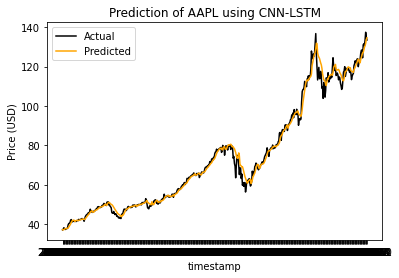

In [159]:
plot_start_date = 20190101
plot_end_date = 20201231
keep = (final_test_y.index >= plot_start_date) & (final_test_y.index <= plot_end_date)
final_pred = pd.DataFrame(data=final_pred,index = final_test_y.index, columns = ["Predicted"])
plot_test_y = final_test_y[keep]
plot_pred = final_pred[keep]

string_index =  plot_test_y.index.map(str)

plt.plot(string_index, plot_test_y["result_price"], label = "Actual", color = 'Black')
plt.plot(string_index, plot_pred["Predicted"], label = "Predicted", color = 'Orange')
plt.xlabel("timestamp")
plt.ylabel("Price (USD)")
plt.title("Prediction of "+stock.upper()+" using CNN-LSTM")

plt.legend()
plt.savefig("plot/CNN_LSTM/"+stock.upper()+"-day("+str(num_day_to_predict)+").jpg",
            dpi=600)
plt.show()

In [24]:
abc = pd.concat([plot_test_y,plot_pred], ignore_index=True, sort=False,axis=1)
abc.columns = ["Actual","Predicted"]
abc

NameError: name 'plot_test_y' is not defined

In [74]:
data

,open,high,low,close,volume,boll,boll_ub,boll_lb,macd,macdh,macds,rsi_11,rsi_14,rsi_21
DATE,,,,,,,,,,,,,,
19840907,0.10150,0.10274,0.10028,0.10150,96970899,0.101500,NaN,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN
19840910,0.10150,0.10181,0.09905,0.10090,75265237,0.101200,0.102049,0.100351,-0.000013,-0.000006,-0.000007,0.000000,0.000000,0.000000
19840911,0.10181,0.10456,0.10181,0.10274,177479896,0.101713,0.103590,0.099837,0.000040,0.000028,0.000012,77.134146,76.758045,76.303318
19840912,0.10274,0.10334,0.09966,0.09966,155043826,0.101200,0.103762,0.098638,-0.000048,-0.000040,-0.000008,31.870001,32.201239,32.592743
19840913,0.10518,0.10548,0.10518,0.10518,241475025,0.101996,0.106191,0.097801,0.000125,0.000094,0.000031,68.412723,68.025100,67.561551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20211021,148.81000,149.64000,147.87000,149.48000,61420990,143.875000,149.793245,137.956755,0.375617,1.069014,-0.693396,65.673205,61.532287,57.199864
20211022,149.69000,150.18000,148.64000,148.69000,58883443,143.963500,150.121546,137.805454,0.577001,1.016318,-0.439317,61.924694,58.867114,55.611436
20211025,148.68000,149.37000,147.62110,148.64000,50720556,144.127000,150.607481,137.646519,0.724216,0.930826,-0.206610,61.679591,58.693837,55.508996


# CNN_LSTM (Direction Prediction)

### Split Data

In [114]:
train_X = custom_split(data,start = 20120101,end = 20161031)
valid_X = custom_split(data,start = 20161101,end = 20171231)
test_X = custom_split(data,start = 20180101,end = 20191231)

### Label the target result

In [115]:
# Assume we use 10 days price data to predict opening price of the 11th day
num_day_to_predict = 10



In [1]:
def produce_result_target_price(X,num_day,result_col_name = "Action"):
    y = pd.DataFrame(np.nan, index=X.index, columns=[result_col_name])
    status = "Hold"
    for i in range(len(X)-num_day):
        last_10_day_mean = np.mean(X.iloc[i:i+num_day,0])
        if X.iloc[i+num_day,0]>last_10_day_mean*1.01:
            y.iloc[i+num_day_to_predict,0] = 1
            status = "Buy"
        elif X.iloc[i+num_day,0]<last_10_day_mean/1.01:
            y.iloc[i+num_day_to_predict,0] = 0
            status = "Sell"
        else:
            if status == "Hold" or status == "Sell":
                y.iloc[i+num_day_to_predict,0] = 0
            elif status == "Buy":
                y.iloc[i+num_day_to_predict,0] = 1
    return y

In [2]:
# y value meaning {1: Buy, 0: Sell}
train_y = produce_result_target_price(train_X,num_day_to_predict)
valid_y = produce_result_target_price(valid_X,num_day_to_predict)
test_y = produce_result_target_price(test_X,num_day_to_predict)




NameError: name 'train_X' is not defined

### Transform the X, y data into tensor

In [119]:
def transform_X_data_to_tensor(X,num_day):
    # Initiate tensor for X
    x_first = X.iloc[0:num_day,:]
    x_mean = x_first.mean(axis=0) # Get the mean of the 10-day frame
    x_std = x_first.std(axis=0) # Get the std of the 10-day frame
    x_first = x_first.sub(x_mean, axis=1).div(x_std, axis=1) # Normalize the 10-day frame here
    x_tf_data = [tf.convert_to_tensor(np.array(x_first),dtype = tf.float32)]
    
    for i in range(1,len(X)-num_day):   
        x_window = X.iloc[i:i+num_day,:] # Set the window as a 10-day frame 
        x_mean = x_window.mean(axis=0) # Get the mean of the 10-day frame
        x_std = x_window.std(axis=0) # Get the std of the 10-day frame
        x_window = x_window.sub(x_mean, axis=1).div(x_std, axis=1) # Normalize the 10-day frame here
        
        x_next_tf = tf.convert_to_tensor(np.array(x_window),dtype = tf.float32)
        x_tf_data = tf.concat([x_tf_data, [x_next_tf]], 0)
        
    return tf.reshape(x_tf_data,(-1,10,14,1))
def transform_y_data_to_tensor(y,num_day):
    temp_y = y.dropna()
    y_tf_data = []
    for ind in temp_y.index:
        if temp_y.loc[ind,"Action"] == 1:
            y_tf_data.append([1,0])
        elif temp_y.loc[ind,"Action"] == 0:
            y_tf_data.append([0,1])
    y_tf_data = tf.convert_to_tensor(y_tf_data)
        
    return y_tf_data



In [120]:
tf_train_X = transform_X_data_to_tensor(train_X,num_day_to_predict)
tf_train_y = transform_y_data_to_tensor(train_y,num_day_to_predict)
tf_valid_X = transform_X_data_to_tensor(valid_X,num_day_to_predict)
tf_valid_y = transform_y_data_to_tensor(valid_y,num_day_to_predict)
tf_test_X = transform_X_data_to_tensor(test_X,num_day_to_predict)
tf_test_y = transform_y_data_to_tensor(test_y,num_day_to_predict)





In [121]:
print(tf_train_X.shape)
print(tf_train_y.shape)
print(tf_train_X.dtype)
print(tf_train_y.dtype)

print(tf_valid_X.shape)
print(tf_valid_y.shape)
print(tf_valid_X.dtype)
print(tf_valid_y.dtype)

print(tf_test_X.shape)
print(tf_test_y.shape)
print(tf_test_X.dtype)
print(tf_test_y.dtype)

(1206, 10, 14, 1)
(1206, 2)
<dtype: 'float32'>
<dtype: 'int32'>
(283, 10, 14, 1)
(283, 2)
<dtype: 'float32'>
<dtype: 'int32'>
(493, 10, 14, 1)
(493, 2)
<dtype: 'float32'>
<dtype: 'int32'>


### Build the Model

In [122]:

def myModel(input_shape,
            encoder_unit = 100,
            repeat_vector_n = 10):
    
    inputs = layers.Input(input_shape)
    
    print("Input: ",inputs.shape)
    
    # First Convolution + MaxPooling + Dropout
    x = layers.Conv2D(filters = 64,kernel_size=(3,3), strides = (1,1), activation='relu', padding='valid')(inputs)
    x = layers.MaxPooling2D(pool_size=(2,2),strides=(2,1), padding='valid')(x)
    x = layers.Dropout(rate = 0.01)(x)
    print("1 Cov: ",x.shape)
    
    # Second Convolution + MaxPooling + Dropout
    x = layers.Conv2D(filters = 16,kernel_size=(3,3), strides = (1,1), activation='relu', padding='valid')(x)
    x = layers.MaxPooling2D(pool_size=(2,2),strides=(2,1), padding='valid')(x)
    x = layers.Dropout(rate = 0.01)(x)
    print("2 Cov: ",x.shape)
    
    # Flatten Layer
    x = layers.Flatten()(x)
    print("Flatten: ",x.shape)
    
    # Repeat Vector Layer
    x = layers.RepeatVector(n = repeat_vector_n)(x)
    print("RepeatVector: ",x.shape)
    
    # Connect to LSTM
    x = layers.LSTM(units = encoder_unit, input_shape=(5,1))(x)
    print("LSTM: ",x.shape)
    
    # Second Flatten Layer
    x = layers.Flatten()(x)
    print("Flatten: ",x.shape)
    
    # Add the Dense Layer with relu activation
    x = layers.Dense(units = 50,activation = "relu")(x)
    print("1 Dense: ",x.shape)
    
    # Add the last Dense Layer with sigmoid activation
    outputs = layers.Dense(units = 2,activation = "softmax")(x)
    print("Output: ",outputs.shape)
    
    return keras.Model(inputs=inputs, outputs=outputs)



### Model Training and Fitting and Validation



In [123]:
optimizer_list = ["Adam"]
epoch_list = [30,50]
batch_list = [50]
encoder_list = [50,100]
lr_list = [0.005,0.01]
train_df = pd.DataFrame(columns = ["Epoch","Batch","Optimizer","LR","Encoder Unit","Loss","Metrics","Validation"])
best_model = ""
best_valid = 99999
metrics = [keras.metrics.RootMeanSquaredError()]


for opti in optimizer_list:
    for epochs in epoch_list:
        for batchs in batch_list:
            for lr in lr_list:
                for encoder_u in encoder_list:

                    model = myModel(input_shape=(num_day_to_predict,train_X.shape[1],1),
                                    encoder_unit = encoder_u,
                                    repeat_vector_n = 100
                                   )

                    if opti == "Adam":
                        optimizer = keras.optimizers.Adam(learning_rate=lr)


                    model.compile(
                        optimizer=optimizer,
                        loss=keras.losses.MeanSquaredError(),
                        metrics=metrics,
                    )

                    history = model.fit(
                            tf_train_X,
                            tf_train_y,
                            epochs = epochs,
                            steps_per_epoch = batchs,
                        )

                    results = model.evaluate(tf_valid_X, tf_valid_y, batch_size=batchs)
                    print(results)
                    print("===== Summary =====")
                    print("Epoch: ",epochs)
                    print("Batch Size: ",batchs)
                    print("Optimizer: ",opti)
                    print("Learning Rate: ",lr)
                    print("Encoder Units: ",encoder_u)
                    print("Loss Function: ", "Categorical CrossEntropy")
                    print("Metrics: ", metrics)
                    print("Validation: ",results)
                    if results[0] < best_valid:
                        best_valid = results[0]
                        best_model = model
                    train_df = train_df.append({"Epoch": epochs,
                                                "Batch": batchs,
                                                "Optimizer": opti,
                                                "LR": lr,
                                                "Encoder Unit": encoder_u,
                                                "Loss": "Categorical CrossEntropy",
                                                "Metrics": metrics,
                                                "Validation":results}, ignore_index=True)
best_model.save("model/cnn_lstm_classify_best")




Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 50)
Flatten:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 1206 samples
Epoch 1/30


2022-03-12 18:56:14.040313: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_295784_296269_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_296442' and '__inference___backward_standard_lstm_295784_296269' both implement 'lstm_838bbf1c-f6c0-4327-9c7e-ad70855fa1fb' but their signatures do not match.


1231/1206 [==============================] - 11s 9ms/sample - loss: 0.1300 - root_mean_squared_error: 0.3603
Epoch 2/30
1231/1206 [==============================] - 9s 7ms/sample - loss: 0.1111 - root_mean_squared_error: 0.3329
Epoch 3/30
1231/1206 [==============================] - 9s 8ms/sample - loss: 0.0782 - root_mean_squared_error: 0.2778
Epoch 4/30
1231/1206 [==============================] - 10s 8ms/sample - loss: 0.0752 - root_mean_squared_error: 0.2689
Epoch 5/30
1231/1206 [==============================] - 10s 8ms/sample - loss: 0.0834 - root_mean_squared_error: 0.2880
Epoch 6/30
1231/1206 [==============================] - 10s 8ms/sample - loss: 0.0666 - root_mean_squared_error: 0.2598
Epoch 7/30
1231/1206 [==============================] - 10s 8ms/sample - loss: 0.0625 - root_mean_squared_error: 0.2548
Epoch 8/30
1231/1206 [==============================] - 10s 8ms/sample - loss: 0.0556 - root_mean_squared_error: 0.2301
Epoch 9/30
1231/1206 [==============================]

2022-03-12 19:01:21.079451: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_301380' and '__inference_standard_lstm_301269_specialized_for_model_15_lstm_15_StatefulPartitionedCall_at___inference_distributed_function_301622' both implement 'lstm_797c1cf5-a0e6-4267-842b-447c2606ddb6' but their signatures do not match.


283/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.12793228177636756, 0.3576762]
===== Summary =====
Epoch:  30
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.005
Encoder Units:  50
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7fae9f582c10>]
Validation:  [0.12793228177636756, 0.3576762]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 100)
Flatten:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 1206 samples
Epoch 1/30


2022-03-12 19:01:24.145790: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_304680_305165_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_305338' and '__inference___backward_cudnn_lstm_with_fallback_304364_304546' both implement 'lstm_221b1772-1964-4c26-9328-b87ac6bccfd9' but their signatures do not match.


1231/1206 [==============================] - 14s 11ms/sample - loss: 0.1343 - root_mean_squared_error: 0.3663
Epoch 2/30
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0895 - root_mean_squared_error: 0.2989
Epoch 3/30
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0778 - root_mean_squared_error: 0.2792
Epoch 4/30
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0613 - root_mean_squared_error: 0.2482
Epoch 5/30
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0652 - root_mean_squared_error: 0.2574
Epoch 6/30
1231/1206 [==============================] - 12s 9ms/sample - loss: 0.0560 - root_mean_squared_error: 0.2366
Epoch 7/30
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0607 - root_mean_squared_error: 0.2468
Epoch 8/30
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0598 - root_mean_squared_error: 0.2412
Epoch 9/30
1231/1206 [======================

2022-03-12 19:07:41.590415: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_310165' and '__inference_standard_lstm_310165_specialized_for_model_16_lstm_16_StatefulPartitionedCall_at___inference_distributed_function_310518' both implement 'lstm_8feaa14f-c455-43f4-9df9-06ac546cab47' but their signatures do not match.


283/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.10063353690315473, 0.3172279]
===== Summary =====
Epoch:  30
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.005
Encoder Units:  100
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7fae9f582c10>]
Validation:  [0.10063353690315473, 0.3172279]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 50)
Flatten:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 1206 samples
Epoch 1/30


2022-03-12 19:07:44.903578: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_313576_314061' and '__inference___backward_standard_lstm_313576_314061_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_314234' both implement 'lstm_a0b85ac0-d434-497d-9fe1-0c27e99f8fd6' but their signatures do not match.


1231/1206 [==============================] - 13s 11ms/sample - loss: 0.1265 - root_mean_squared_error: 0.3561
Epoch 2/30
1231/1206 [==============================] - 11s 9ms/sample - loss: 0.1213 - root_mean_squared_error: 0.3474
Epoch 3/30
1231/1206 [==============================] - 11s 9ms/sample - loss: 0.0910 - root_mean_squared_error: 0.3006
Epoch 4/30
1231/1206 [==============================] - 11s 9ms/sample - loss: 0.0768 - root_mean_squared_error: 0.2764
Epoch 5/30
1231/1206 [==============================] - 11s 9ms/sample - loss: 0.0735 - root_mean_squared_error: 0.2713
Epoch 6/30
1231/1206 [==============================] - 10s 9ms/sample - loss: 0.0713 - root_mean_squared_error: 0.2694
Epoch 7/30
1231/1206 [==============================] - 11s 9ms/sample - loss: 0.0735 - root_mean_squared_error: 0.2745
Epoch 8/30
1231/1206 [==============================] - 11s 9ms/sample - loss: 0.0609 - root_mean_squared_error: 0.2452
Epoch 9/30
1231/1206 [============================

2022-03-12 19:13:22.349147: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_319061_specialized_for_model_17_lstm_17_StatefulPartitionedCall_at___inference_distributed_function_319414' and '__inference_standard_lstm_319061' both implement 'lstm_79952b33-3f76-4299-9ed0-9188a0a55fbf' but their signatures do not match.


283/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.0805631507148591, 0.28383648]
===== Summary =====
Epoch:  30
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.01
Encoder Units:  50
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7fae9f582c10>]
Validation:  [0.0805631507148591, 0.28383648]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 100)
Flatten:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 1206 samples
Epoch 1/30


2022-03-12 19:13:29.446836: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_322156_322338' and '__inference___backward_standard_lstm_322472_322957_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_323130' both implement 'lstm_e0717f27-707a-4c71-a466-0421be2e0586' but their signatures do not match.


1231/1206 [==============================] - 18s 14ms/sample - loss: 0.1477 - root_mean_squared_error: 0.3836
Epoch 2/30
1231/1206 [==============================] - 13s 10ms/sample - loss: 0.0986 - root_mean_squared_error: 0.3174
Epoch 3/30
1231/1206 [==============================] - 13s 10ms/sample - loss: 0.0800 - root_mean_squared_error: 0.2838
Epoch 4/30
1231/1206 [==============================] - 13s 10ms/sample - loss: 0.0719 - root_mean_squared_error: 0.2725
Epoch 5/30
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0639 - root_mean_squared_error: 0.2519
Epoch 6/30
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0681 - root_mean_squared_error: 0.2595
Epoch 7/30
1231/1206 [==============================] - 13s 11ms/sample - loss: 0.0562 - root_mean_squared_error: 0.2400
Epoch 8/30
1231/1206 [==============================] - 14s 11ms/sample - loss: 0.0781 - root_mean_squared_error: 0.2771
Epoch 9/30
1231/1206 [=====================

2022-03-12 19:19:59.737921: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_327957' and '__inference_standard_lstm_327957_specialized_for_model_18_lstm_18_StatefulPartitionedCall_at___inference_distributed_function_328310' both implement 'lstm_c7570c8d-fdcc-4917-a654-839a9bf36db6' but their signatures do not match.


283/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.06812245608060605, 0.26100278]
===== Summary =====
Epoch:  30
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.01
Encoder Units:  100
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7fae9f582c10>]
Validation:  [0.06812245608060605, 0.26100278]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 50)
Flatten:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 1206 samples
Epoch 1/50


2022-03-12 19:20:03.507133: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_331368_331853_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_332026' and '__inference___backward_cudnn_lstm_with_fallback_331052_331234' both implement 'lstm_c85d9d1a-1ea8-4df8-a3f3-7a96fe17fdb5' but their signatures do not match.


1231/1206 [==============================] - 14s 12ms/sample - loss: 0.1446 - root_mean_squared_error: 0.3798
Epoch 2/50
1231/1206 [==============================] - 11s 9ms/sample - loss: 0.0900 - root_mean_squared_error: 0.3003
Epoch 3/50
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0806 - root_mean_squared_error: 0.2843
Epoch 4/50
1231/1206 [==============================] - 13s 10ms/sample - loss: 0.0722 - root_mean_squared_error: 0.2673
Epoch 5/50
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0630 - root_mean_squared_error: 0.2513
Epoch 6/50
1231/1206 [==============================] - 12s 9ms/sample - loss: 0.0604 - root_mean_squared_error: 0.2466
Epoch 7/50
1231/1206 [==============================] - 12s 9ms/sample - loss: 0.0522 - root_mean_squared_error: 0.2292
Epoch 8/50
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0621 - root_mean_squared_error: 0.2559
Epoch 9/50
1231/1206 [========================

2022-03-12 19:29:47.873891: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_lstm_with_fallback_340004' and '__inference_standard_lstm_339893_specialized_for_model_19_lstm_19_StatefulPartitionedCall_at___inference_distributed_function_340246' both implement 'lstm_928d7685-51af-442b-a4ff-b3236d4b4c07' but their signatures do not match.


283/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.12077951965715354, 0.34753346]
===== Summary =====
Epoch:  50
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.005
Encoder Units:  50
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7fae9f582c10>]
Validation:  [0.12077951965715354, 0.34753346]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 100)
Flatten:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 1206 samples
Epoch 1/50


2022-03-12 19:29:52.164071: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_343304_343789_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_343962' and '__inference___backward_standard_lstm_343304_343789' both implement 'lstm_49025b24-22dc-46a0-9021-47d42d5c0807' but their signatures do not match.


1231/1206 [==============================] - 17s 14ms/sample - loss: 0.1318 - root_mean_squared_error: 0.3635
Epoch 2/50
1231/1206 [==============================] - 14s 11ms/sample - loss: 0.0832 - root_mean_squared_error: 0.2863
Epoch 3/50
1231/1206 [==============================] - 14s 11ms/sample - loss: 0.0716 - root_mean_squared_error: 0.2659
Epoch 4/50
1231/1206 [==============================] - 13s 11ms/sample - loss: 0.0815 - root_mean_squared_error: 0.2860
Epoch 5/50
1231/1206 [==============================] - 13s 11ms/sample - loss: 0.0672 - root_mean_squared_error: 0.2609
Epoch 6/50
1231/1206 [==============================] - 14s 12ms/sample - loss: 0.0561 - root_mean_squared_error: 0.2352
Epoch 7/50
1231/1206 [==============================] - 14s 12ms/sample - loss: 0.1055 - root_mean_squared_error: 0.3254
Epoch 8/50
1231/1206 [==============================] - 13s 11ms/sample - loss: 0.1010 - root_mean_squared_error: 0.3160
Epoch 9/50
1231/1206 [=====================

2022-03-12 19:40:50.447234: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_351829' and '__inference_standard_lstm_351829_specialized_for_model_20_lstm_20_StatefulPartitionedCall_at___inference_distributed_function_352182' both implement 'lstm_b4a17b5c-96c4-434d-8a04-2112b1ad55d0' but their signatures do not match.


283/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.15075570950449144, 0.38827273]
===== Summary =====
Epoch:  50
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.005
Encoder Units:  100
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7fae9f582c10>]
Validation:  [0.15075570950449144, 0.38827273]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 50)
Flatten:  (None, 50)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 1206 samples
Epoch 1/50


2022-03-12 19:40:54.505627: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_cudnn_lstm_with_fallback_354924_355106' and '__inference___backward_standard_lstm_355240_355725_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_355898' both implement 'lstm_5ffad706-c78e-4431-bc7b-285e52f65c88' but their signatures do not match.


1231/1206 [==============================] - 15s 12ms/sample - loss: 0.1172 - root_mean_squared_error: 0.3431
Epoch 2/50
1231/1206 [==============================] - 12s 9ms/sample - loss: 0.1104 - root_mean_squared_error: 0.3310
Epoch 3/50
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0939 - root_mean_squared_error: 0.3081
Epoch 4/50
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0788 - root_mean_squared_error: 0.2832
Epoch 5/50
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0739 - root_mean_squared_error: 0.2716
Epoch 6/50
1231/1206 [==============================] - 11s 9ms/sample - loss: 0.0745 - root_mean_squared_error: 0.2777
Epoch 7/50
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0864 - root_mean_squared_error: 0.2929
Epoch 8/50
1231/1206 [==============================] - 12s 10ms/sample - loss: 0.0855 - root_mean_squared_error: 0.2967
Epoch 9/50
1231/1206 [=======================

2022-03-12 19:51:06.342497: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_363765' and '__inference_standard_lstm_363765_specialized_for_model_21_lstm_21_StatefulPartitionedCall_at___inference_distributed_function_364118' both implement 'lstm_5088a076-09f3-46fc-9969-a4e4d55c3c88' but their signatures do not match.


283/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.0945959239934864, 0.3075645]
===== Summary =====
Epoch:  50
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.01
Encoder Units:  50
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7fae9f582c10>]
Validation:  [0.0945959239934864, 0.3075645]
Input:  (None, 10, 14, 1)
1 Cov:  (None, 4, 11, 64)
2 Cov:  (None, 1, 8, 16)
Flatten:  (None, 128)
RepeatVector:  (None, 100, 128)
LSTM:  (None, 100)
Flatten:  (None, 100)
1 Dense:  (None, 50)
Output:  (None, 2)
Train on 1206 samples
Epoch 1/50


2022-03-12 19:51:10.245110: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_lstm_367176_367661' and '__inference___backward_standard_lstm_367176_367661_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_367834' both implement 'lstm_155d743e-b541-4ffc-9766-ff4d7fb41860' but their signatures do not match.


1231/1206 [==============================] - 16s 13ms/sample - loss: 0.1560 - root_mean_squared_error: 0.3949
Epoch 2/50
1231/1206 [==============================] - 13s 10ms/sample - loss: 0.1380 - root_mean_squared_error: 0.3706
Epoch 3/50
1231/1206 [==============================] - 13s 11ms/sample - loss: 0.0960 - root_mean_squared_error: 0.3111
Epoch 4/50
1231/1206 [==============================] - 13s 11ms/sample - loss: 0.0993 - root_mean_squared_error: 0.3136
Epoch 5/50
1231/1206 [==============================] - 13s 11ms/sample - loss: 0.0942 - root_mean_squared_error: 0.3088
Epoch 6/50
1231/1206 [==============================] - 13s 11ms/sample - loss: 0.0748 - root_mean_squared_error: 0.2717
Epoch 7/50
1231/1206 [==============================] - 13s 10ms/sample - loss: 0.0893 - root_mean_squared_error: 0.2962
Epoch 8/50
1231/1206 [==============================] - 14s 11ms/sample - loss: 0.0704 - root_mean_squared_error: 0.2669
Epoch 9/50
1231/1206 [=====================

2022-03-12 20:01:53.084849: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_lstm_375701' and '__inference_standard_lstm_375701_specialized_for_model_22_lstm_22_StatefulPartitionedCall_at___inference_distributed_function_376054' both implement 'lstm_32c9c7c2-857c-464a-b710-09737151880e' but their signatures do not match.


283/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.09299092046100343, 0.30494413]
===== Summary =====
Epoch:  50
Batch Size:  50
Optimizer:  Adam
Learning Rate:  0.01
Encoder Units:  100
Loss Function:  Categorical CrossEntropy
Metrics:  [<tensorflow.python.keras.metrics.RootMeanSquaredError object at 0x7fae9f582c10>]
Validation:  [0.09299092046100343, 0.30494413]
INFO:tensorflow:Assets written to: model/cnn_lstm_classify_best/assets


### Model Testing

In [124]:
loaded_model = keras.models.load_model('model/cnn_lstm_classify_best')
predictions = loaded_model.predict(tf_test_X)

In [125]:
print("predictions shape:", predictions.shape)
print(predictions)

predictions shape: (493, 2)
[[0.99592364 0.00407638]
 [0.9956215  0.00437855]
 [0.99581546 0.00418453]
 [0.9883577  0.0116423 ]
 [0.9934089  0.00659111]
 [0.99180263 0.00819742]
 [0.06043568 0.93956435]
 [0.03372977 0.9662702 ]
 [0.01021304 0.989787  ]
 [0.00971145 0.9902886 ]
 [0.01123999 0.98876   ]
 [0.00353817 0.9964618 ]
 [0.00359634 0.9964037 ]
 [0.00487208 0.9951279 ]
 [0.00307662 0.9969234 ]
 [0.00317898 0.99682105]
 [0.013501   0.98649895]
 [0.00551987 0.99448013]
 [0.01151958 0.98848045]
 [0.02495917 0.97504085]
 [0.8699542  0.13004583]
 [0.9415485  0.05845151]
 [0.99271977 0.00728025]
 [0.99270105 0.00729891]
 [0.9936953  0.00630464]
 [0.993415   0.00658504]
 [0.9936401  0.00635982]
 [0.994379   0.00562095]
 [0.9927942  0.0072058 ]
 [0.99342066 0.00657933]
 [0.9868461  0.01315391]
 [0.9865159  0.0134841 ]
 [0.9101009  0.08989918]
 [0.905978   0.09402198]
 [0.9175549  0.08244506]
 [0.91486025 0.08513978]
 [0.90275025 0.09724974]
 [0.9520911  0.0479089 ]
 [0.98979425 0.0102058

In [126]:
def convert_decision(test,pred):
    h = np.array(pred)
    action = []
    status = "N"
    for i in range(len(h)):
        if h[i][0] == max(h[i]):
            h[i] = [1,0]
            if status == "N":
                action.append("Buy")
                status = "Buy"
            else:
                action.append("Hold")
        else:
            h[i] = [0,1]
            if status == "Buy":
                action.append("Sell")
                status = "N"
            else:
                action.append("Hold")
                
    backtest = test[["open"]][10:]
    backtest.columns = ["Open"]
    return (backtest,pd.DataFrame(action,index=test[10:].index,columns=["Action"]))



In [127]:
backtestdata,final_pred = convert_decision(test_X,predictions)
final_pred

,Action
DATE,
20180117,Buy
20180118,Hold
20180119,Hold
20180122,Hold
20180123,Hold
...,...
20191224,Hold
20191226,Hold
20191227,Hold


### Backtesting

In [134]:
################### Input ##########################
# For hist_price_data: index=["date"], columns = ["Open"]
# For pred_action: index=["date"], columns = ["Action"] (Buy/Sell)
################### Output #########################
# 1. trading record
# 2. total profit
class backtest:
    hpd = ""
    pred_action=""
    trade_record=pd.DataFrame(index=[],
                              columns=["Action","Price","Position","Cash","Pos_Bal","Cash_Bal","Cum_Profit"],
                             )
    capital = 0
    cash_balance = 0
    profit = 0
    handle_fee = 0
    position = 0
    last_price = 0
    
    def __init__(self,hist_price_data,pred_action,capital,handling_fee):
        self.hpd = hist_price_data
        self.pred_action = pred_action
        self.capital = capital
        self.cash_balance = capital
        self.handle_fee = handling_fee
        trade_record=pd.DataFrame(index=[],
                                  columns=["Action","Price","Position","Cash","Pos_Bal","Cash_Bal","Cum_Profit"],
                                 )
        
    def start_test(self):        
        # For loop to iterate the data
        for ind in self.pred_action.index:
            # Update latest price
            self.last_price = self.hpd.loc[ind,"Open"]
            
            if self.pred_action.loc[ind,"Action"].lower() == "buy":
                self.buy(ind,self.hpd.loc[ind,"Open"])
            elif self.pred_action.loc[ind,"Action"].lower() == "sell":
                self.sell(ind,self.hpd.loc[ind,"Open"])
            else:
                print("Did not buy at " + str(ind))
            
                
        
    def mark_down_record(self,date,action,price,pos_delta,cash_delta):
        self.trade_record.loc[date,"Action"] = action
        self.trade_record.loc[date,"Price"] = price
        self.trade_record.loc[date,"Position"] = pos_delta
        self.trade_record.loc[date,"Cash"] = cash_delta
        
        self.trade_record.loc[date,"Pos_Bal"] = round(self.position,4)
        self.trade_record.loc[date,"Cash_Bal"] = round(self.cash_balance,3)
        self.trade_record.loc[date,"Cum_Profit"] = round(self.get_profit(),3)
        
    def buy(self,date,price):
        # Assume use all money to buy all
        buy_flag = False
        buy_pos = floor(self.cash_balance / price)
        for i in range(buy_pos):
            act_buy_pos = buy_pos - i
            total_amt = act_buy_pos*price*(1+self.handle_fee)
            if self.cash_balance > total_amt:
                self.position += act_buy_pos
                self.cash_balance -= total_amt
                self.mark_down_record(date,
                                 "Buy",
                                 price,
                                 act_buy_pos,
                                 -total_amt)
                print("Bought at",date,"with price =", price)
                buy_flag = True
                break
        if not buy_flag:
            print("You do not have enough money to buy!")
    
    def sell(self,date,price):
        # Assume sell all position
        sell_pos = self.position
        total_amt = sell_pos*price*(1-self.handle_fee)
        if self.position >= 1:
            self.position -= sell_pos
            self.cash_balance += total_amt
            self.mark_down_record(date,
                             "Sell",
                             price,
                             -sell_pos,
                             total_amt)
            print("Sold at",date,"with price =", price)
        else:
            print("You do not have enough position to sell!")
    
    def get_profit(self):
        return self.get_cash_balance()+self.get_last_price()*self.get_position()-self.get_capital()
    
    def get_capital(self):
        return self.capital
    
    def get_last_price(self):
        return self.last_price
    
    def get_cash_balance(self):
        return self.cash_balance
    
    def get_position(self):
        return self.position
    
    def get_amounnt(self):
        return self.capital+self.profit
    
    def print_trade_record(self):
        print(self.trade_record)
    
    def print_profit(self):
        print("Current Profit:",self.get_profit())
    
    def export_trade_record(self,stock):
        # Save the trade record to the path
        self.trade_record.to_csv("trade_record/"+stock+".csv")

In [135]:
def do_nothing(backtest,capital):
    balance = capital
    first_price = backtest.iloc[0,0]
    last_price = backtest.iloc[-1,0]
    buy_pos = floor(capital / first_price)
    total_amt = buy_pos*first_price*(1+handling_fee)
    while capital < total_amt:
        buy_pos -= 1
        total_amt = buy_pos*first_price*(1+handling_fee)
    position = buy_pos
    balance -= total_amt
    print("If buy at", backtest.index[0],"with price =",first_price)
    print("and do nothing")
    print("Current Profit:",last_price*position+balance-capital)

In [136]:
backtest_1 = backtest(backtestdata,final_pred,10000,0.002)

In [137]:
backtest_1.start_test()

Bought at 20180117 with price = 42.181
Did not buy at 20180118
Did not buy at 20180119
Did not buy at 20180122
Did not buy at 20180123
Did not buy at 20180124
Sold at 20180125 with price = 41.783
Did not buy at 20180126
Did not buy at 20180129
Did not buy at 20180130
Did not buy at 20180131
Did not buy at 20180201
Did not buy at 20180202
Did not buy at 20180205
Did not buy at 20180206
Did not buy at 20180207
Did not buy at 20180208
Did not buy at 20180209
Did not buy at 20180212
Did not buy at 20180213
Bought at 20180214 with price = 39.197
Did not buy at 20180215
Did not buy at 20180216
Did not buy at 20180220
Did not buy at 20180221
Did not buy at 20180222
Did not buy at 20180223
Did not buy at 20180226
Did not buy at 20180227
Did not buy at 20180228
Did not buy at 20180301
Did not buy at 20180302
Did not buy at 20180305
Did not buy at 20180306
Did not buy at 20180307
Did not buy at 20180308
Did not buy at 20180309
Did not buy at 20180312
Did not buy at 20180313
Did not buy at 201803

In [138]:

backtest_1.print_trade_record()
print('==========================')
backtest_1.export_trade_record("AAPL")
backtest_1.print_profit()

         Action   Price Position          Cash Pos_Bal   Cash_Bal Cum_Profit
20180117    Buy  42.181      236  -9974.625432     236     25.375    -19.909
20180125   Sell  41.783     -236   9841.066424       0   9866.441   -133.559
20180214    Buy  39.197      251  -9858.123894     251      8.317   -153.236
20180321   Sell  42.087     -251  10542.709326       0  10551.026    551.026
20180406    Buy  41.105      256  -10543.92576     256      7.101    529.981
20180423   Sell  40.112     -256  10248.134656       0  10255.235    255.235
20180502    Buy  42.131      242 -10216.093404     242     39.142    234.844
20180614   Sell  46.235     -242   11166.49226       0  11205.634   1205.634
20180706    Buy  44.754      249 -11166.033492     249     39.601   1183.347
20180911   Sell    52.8     -249    13120.9056       0  13160.506   3160.506
20180924    Buy  52.517      250   -13155.5085     250      4.998   3134.248
20180925   Sell  53.222     -250     13278.889       0  13283.887   3283.887

In [139]:
# If do nothing
do_nothing(backtestdata,10000)

If buy at 20180117 with price = 42.181
Current Profit: 6905.274568000001


### Other data range testing

In [142]:
abc_test = custom_split(data,start = 20190101,end = 20210930)
tf_abc_test= transform_X_data_to_tensor(abc_test,num_day_to_predict)
predictions = loaded_model.predict(tf_abc_test)
backtest_data,pred = convert_decision(abc_test,predictions)
capital = 10000
handling_fee = 0.002 
backtest_abc = backtest(backtest_data,pred,capital,handling_fee)
backtest_abc.start_test()
backtest_abc.print_trade_record()
print('==========================')
backtest_abc.export_trade_record("AAPL (abc)")
backtest_abc.print_profit()

Bought at 20190116 with price = 37.209
Did not buy at 20190117
Did not buy at 20190118
Did not buy at 20190122
Did not buy at 20190123
Did not buy at 20190124
Did not buy at 20190125
Did not buy at 20190128
Did not buy at 20190129
Did not buy at 20190130
Did not buy at 20190131
Did not buy at 20190201
Did not buy at 20190204
Did not buy at 20190205
Did not buy at 20190206
Did not buy at 20190207
Did not buy at 20190208
Did not buy at 20190211
Did not buy at 20190212
Did not buy at 20190213
Did not buy at 20190214
Did not buy at 20190215
Did not buy at 20190219
Did not buy at 20190220
Did not buy at 20190221
Did not buy at 20190222
Did not buy at 20190225
Did not buy at 20190226
Did not buy at 20190227
Did not buy at 20190228
Did not buy at 20190301
Did not buy at 20190304
Did not buy at 20190305
Did not buy at 20190306
Did not buy at 20190307
Did not buy at 20190308
Sold at 20190311 with price = 42.837
Bought at 20190312 with price = 43.937
Did not buy at 20190313
Did not buy at 201903

In [143]:
do_nothing(backtest_data,capital)

If buy at 20190116 with price = 37.209
Current Profit: 28508.923976


# Support Vectore Rgression

### Split the train and test data

In [144]:
train_X = custom_split(data,start = 20130101,end = 20171031)
valid_X = custom_split(data,start = 20171101,end = 20181231)
test_X = custom_split(data,start = 20190101,end = 20201231)

### Label the target result (opening price on 11th day)

In [145]:
# Assume we use 10 days price data to predict closing price of the 11th day
num_day_to_predict = 10

In [146]:
def produce_result_target_price(X,num_day = 10,result_col_name = "result_price"):
    y = pd.DataFrame(np.nan, index=X.index, columns=[result_col_name])
    for i in range(10,len(X)):
        y.loc[X.index[i-1],result_col_name] = X.loc[X.index[i],"open"]
    
    return y

In [147]:
train_y = produce_result_target_price(train_X,num_day_to_predict)
valid_y = produce_result_target_price(valid_X,num_day_to_predict)
test_y = produce_result_target_price(test_X,num_day_to_predict)

In [148]:
test_y.head(20)

,result_price
DATE,
20190102,NaN
20190103,NaN
20190104,NaN
20190107,NaN
20190108,NaN
20190109,NaN
20190110,NaN
20190111,NaN
20190114,NaN


### Transform the 10-day data into one vector

In [149]:
def transform_x_data_to_one_vector(X,num_day = 10):
    col_name = []
    for i in range(num_day):
        for j in X.columns:
            col_name.append(j+"-"+str(i))
    new_X = pd.DataFrame(np.nan, index=X.index, columns=col_name)
    
    for i in range(len(X)-9):
        for col in col_name:
            split_list = col.split("-")
            new_X.loc[X.index[i],col] = X.loc[X.index[i+int(split_list[1])],split_list[0]]
    
    return new_X

In [150]:
train_X_10 = transform_x_data_to_one_vector(train_X,num_day_to_predict)
valid_X_10 = transform_x_data_to_one_vector(valid_X,num_day_to_predict)
test_X_10 = transform_x_data_to_one_vector(test_X,num_day_to_predict)

In [151]:
test_X_10.tail(20)

,open-0,high-0,low-0,close-0,volume-0,boll-0,boll_ub-0,boll_lb-0,macd-0,macdh-0,...,volume-9,boll-9,boll_ub-9,boll_lb-9,macd-9,macdh-9,macds-9,rsi_11-9,rsi_14-9,rsi_21-9
DATE,,,,,,,,,,,,,,,,,,,,,
20201203,122.95,123.21,121.64,122.37,79338657.0,117.9900,122.997838,112.982162,1.401129,0.596780,...,98670020.0,120.3710,128.205931,112.536069,2.307306,0.516992,1.790315,68.375418,65.754417,61.740894
20201204,122.03,122.29,120.95,121.68,78628125.0,118.1610,123.434189,112.887811,1.524915,0.576453,...,94803157.0,120.9025,129.328724,112.476276,2.557105,0.613432,1.943673,70.004702,67.108619,62.687681
20201207,121.74,123.98,121.68,123.18,87025034.0,118.4135,124.144216,112.682784,1.724178,0.620572,...,193446146.0,121.3020,129.920225,112.683775,2.561737,0.494452,2.067286,61.991552,61.167224,59.180247
20201208,123.78,124.39,122.52,123.79,82394044.0,118.8140,124.879583,112.748417,1.909308,0.644562,...,121821249.0,121.8440,130.629283,113.058717,2.660618,0.474666,2.185952,65.344800,63.818244,60.943515
20201209,123.94,125.36,120.44,121.21,115416170.0,119.1030,125.039109,113.166891,1.826782,0.449629,...,170147519.0,122.7410,131.525208,113.956792,2.997341,0.649111,2.348230,71.728940,69.103755,64.672046
20201210,119.94,123.30,119.59,122.67,81693881.0,119.2900,125.435119,113.144881,1.857774,0.384497,...,88638209.0,123.5265,132.062951,114.990049,3.153607,0.644302,2.509305,68.225040,66.454125,63.069773
20201211,121.86,122.19,119.99,121.84,87348270.0,119.4495,125.689539,113.209461,1.794674,0.257117,...,55188152.0,124.3195,132.656887,115.982113,3.320669,0.649091,2.671578,69.995053,67.908870,64.095178
20201214,122.03,122.78,120.97,121.21,79447525.0,119.5750,125.852420,113.297580,1.674528,0.109577,...,125071132.0,125.3200,134.259761,116.380239,3.789442,0.894291,2.895151,76.663435,73.647994,68.392452
20201215,123.75,127.30,123.54,127.28,158312610.0,119.9520,127.114412,112.789588,2.045530,0.384463,...,121616061.0,126.1075,135.285634,116.929366,3.968345,0.858555,3.109790,70.046495,68.546679,65.225111


### Drop out rows with NaN

In [152]:
def drop_nan_row_y(y,num_day = 10):
    drop_list = [y.index[i] for i in range(num_day-1)]
    drop_list.append(y.index[-1])
    return y.drop(drop_list)

def drop_nan_row_X_10(X,num_day = 10):
    drop_list = [X.index[-i] for i in range(1,num_day+1)]
    return X.drop(drop_list)

In [195]:
new_train_X_10 = drop_nan_row_X_10(train_X_10,num_day_to_predict)
new_train_y = drop_nan_row_y(train_y,num_day_to_predict)

new_valid_X_10  = drop_nan_row_X_10(valid_X_10,num_day_to_predict)
new_valid_y = drop_nan_row_y(valid_y,num_day_to_predict)

new_test_X_10  = drop_nan_row_X_10(test_X_10,num_day_to_predict)
new_test_y = drop_nan_row_y(test_y,num_day_to_predict)




In [196]:
# Keep a copy for reverting prediction result
old_train_X_10 = new_train_X_10
old_train_y = new_train_y
old_valid_X_10 = new_valid_X_10
old_valid_y = new_valid_y
old_test_X_10 = new_test_X_10
old_test_y = new_test_y

In [197]:
### Normalize data row by row

In [198]:
def normalize_data_by_row(X,y):
    norm_X = X.sub(X.mean(axis=0), axis=1).div(X.std(axis=0), axis=1)
    
    col_list =[] 
    for col in X.columns:
        if "open" in col:
            col_list.append(col)
    
    temp_y = y.loc[:,"result_price"]
    mean_10_day = np.mean(X.loc[:,col_list],axis=1)
    mean_10_day.index = temp_y.index
    std_10_day = np.std(X.loc[:,col_list],axis=1)
    std_10_day.index = temp_y.index

    norm_y = pd.DataFrame((temp_y-mean_10_day)/std_10_day,
                          columns=["result_price"])
                         
    return (norm_X,norm_y)

In [199]:
new_train_X_10,new_train_y = normalize_data_by_row(new_train_X_10,new_train_y)
new_valid_X_10,new_valid_y = normalize_data_by_row(new_valid_X_10,new_valid_y)
new_test_X_10,new_test_y = normalize_data_by_row(new_test_X_10,new_test_y)

### Model Training and Fitting

/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 1000 ): 0.7235581352332495


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 1100 ): 0.7239241818834927


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 1200 ): 0.7245001509788604


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 1300 ): 0.7250177684605499


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 1400 ): 0.7247148893057564


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 1500 ): 0.7246616695515463


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 1600 ): 0.724784026887165


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 1700 ): 0.7247970544595882


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 1800 ): 0.7251653972992237


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 1900 ): 0.7253681949889405


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 2000 ): 0.7254456268581024


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 2100 ): 0.7251926827640618


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 2200 ): 0.7248080504978928


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 2300 ): 0.7245806460530338


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 2400 ): 0.7246226561483711


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 2500 ): 0.7246982243696107


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 2600 ): 0.7244217374336381


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 2700 ): 0.7242689573866239


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 2800 ): 0.7241051975093571


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 2900 ): 0.7244479107761488


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (c = 3000 ): 0.7242927405851719


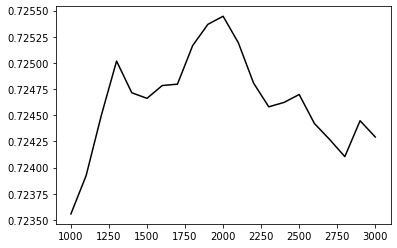

In [200]:
# Use Support Vector Regressor to fit the data

# C : Regularization parameter. The strength of the regularization is inversely proportional to C.
c_list = [i*100 for i in range(10,31)]
svr_conf_list = []
for c in c_list:
    # gamma : Kernel coefficient
    gamma = 0.00001

    # radial basis function kernel
    kernel="rbf"

    svr = SVR(kernel=kernel, C=c, gamma=gamma)
    svr.fit(new_train_X_10, new_train_y)

    svr_prediction = svr.predict(new_valid_X_10)
    svr_confidence = svr.score(new_valid_X_10, new_valid_y)
    print("svr confidence (c =", c,"):", svr_confidence)
    svr_conf_list.append(svr_confidence)
    
plt.plot(c_list, svr_conf_list, label = "C to SVR Confid", color = 'Black')

In [201]:
# Choose C = 2000

/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 1e-07 ): 0.47287864805978785


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 5e-07 ): 0.6475434324100067


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 1e-06 ): 0.683127776588939


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 5e-06 ): 0.7227733340863576


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 1e-05 ): 0.7254456268581024


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 5e-05 ): 0.694233234018548


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 0.0001 ): 0.6589458003049283


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence (gamma = 0.0005 ): 0.3569402866376521


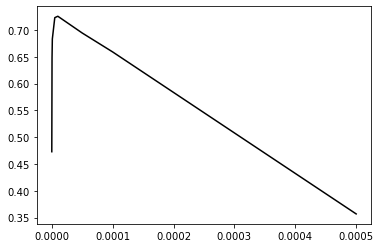

In [202]:
# Use Support Vector Regressor to fit the data

# gamma : Kernel coefficient

gamma_list = [0.0000001,0.0000005,0.000001,0.000005,0.00001,0.00005,0.0001,0.0005]
svr_conf_list = []
for gamma in gamma_list:
    # C : Regularization parameter. The strength of the regularization is inversely proportional to C.
    c = 2000

    # radial basis function kernel
    kernel="rbf"

    svr = SVR(kernel=kernel, C=c, gamma=gamma)
    svr.fit(new_train_X_10, new_train_y)

    svr_prediction = svr.predict(new_valid_X_10)
    svr_confidence = svr.score(new_valid_X_10, new_valid_y)
    print("svr confidence (gamma =", gamma,"):", svr_confidence)
    svr_conf_list.append(svr_confidence)
    
plt.plot(gamma_list, svr_conf_list, label = "gamma to SVR Confid", color = 'Black')

In [203]:
# Choose gamma = 0.00001

In [204]:
new_test_y

,result_price
DATE,
20190115,0.952664
20190116,1.444389
20190117,2.540515
20190118,1.778729
20190122,0.525108
...,...
20201223,1.291615
20201224,1.856580
20201228,2.645082


### Model Testing

In [205]:
# C : Regularization parameter. The strength of the regularization is inversely proportional to C.
c = 2000

# gamma : Kernel coefficient
gamma = 0.00001

# radial basis function kernel
kernel="rbf"

svr = SVR(kernel=kernel, C=c, gamma=gamma)
svr.fit(new_train_X_10, new_train_y)

svr_prediction = svr.predict(new_test_X_10)
svr_confidence = svr.score(new_test_X_10, new_test_y)
print("svr confidence:", svr_confidence)


/Users/anthonykwok/opt/anaconda3/envs/tf/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


svr confidence: 0.5085239228056166


In [242]:
def convert_prediction(X,y,pred):
    col_list =[] 
    for col in X.columns:
        if "open" in col:
            col_list.append(col)
        
    mean_10_day = np.mean(X.loc[:,col_list],axis=1)
    mean_10_day.index = y.index
    std_10_day = np.std(X.loc[:,col_list],axis=1)
    std_10_day.index = y.index
    a = pd.DataFrame(index = y.index,columns=['mean','std','pred'])
    a.loc[:,"mean"] = mean_10_day
    a.loc[:,"std"] = std_10_day
    a.loc[:,"pred"] = pred
    a.loc[:,"converted"] = pred*std_10_day+mean_10_day
    return a

In [245]:
pred_df = convert_prediction(old_test_X_10,old_test_y,svr_prediction)
converted_pred = pred_df.loc[:,"converted"]
converted_pred

DATE
20190115     36.188778
20190116     36.437432
20190117     36.774204
20190118     37.175170
20190122     36.812467
               ...    
20201223    130.354244
20201224    131.408131
20201228    136.413308
20201229    133.559331
20201230    132.070397
Name: converted, Length: 495, dtype: float64

In [227]:
old_test_y

,result_price
DATE,
20190115,37.209
20190116,37.477
20190117,38.280
20190118,38.013
20190122,37.464
...,...
20201223,130.700
20201224,133.360
20201228,137.400


In [246]:
print("Mean Absoluted Error")
np.mean(abs(np.array(old_test_y.loc[:,])-converted_pred)) ## Mean Absolute Error of the prediction

Mean Absoluted Error


ValueError: Data must be 1-dimensional

### Plot the graph

In [ ]:
plt.plot(old_test_y.index, old_test_y["result_price"], label = "Actual", color = 'Black')
plt.plot(reverted_predict_y.index, reverted_predict_y, label = "Predicted", color = 'Orange')
plt.xlabel("timestamp")
plt.ylabel("Price (USD)")
plt.title("Prediction of "+stock.upper()+" using SVR")

plt.legend()
plt.savefig("plot/SVR/"+stock.upper()+"-day("+str(num_day_to_predict)+")kernel("+kernel+")C("+str(C)+")gamma("+str(gamma)+")confidence("+str(round(svm_confidence,5))+").jpg",
            dpi=600)
plt.show()





